In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from pandas.io.parsers import read_csv
import datetime as dt
import time
from PIL import Image
from K.utils.load import load_test_data
from K.utils.models import load_models_with_weights
from K.utils.constant import *

/Users/sanghapark/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/Users/sanghapark/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
cols01 = [
    'left_eye_center_x',            'left_eye_center_y',
    'right_eye_center_x',           'right_eye_center_y',
    'nose_tip_x',                   'nose_tip_y',
    'mouth_center_bottom_lip_x',    'mouth_center_bottom_lip_y'
]
cols02 = [

    'left_eye_inner_corner_x',      'left_eye_inner_corner_y',
    'left_eye_outer_corner_x',      'left_eye_outer_corner_y',
    'right_eye_inner_corner_x',     'right_eye_inner_corner_y',
    'right_eye_outer_corner_x',     'right_eye_outer_corner_y',
    'left_eyebrow_inner_end_x',     'left_eyebrow_inner_end_y',
    'left_eyebrow_outer_end_x',     'left_eyebrow_outer_end_y',
    'right_eyebrow_inner_end_x',    'right_eyebrow_inner_end_y',
    'right_eyebrow_outer_end_x',    'right_eyebrow_outer_end_y',

    'mouth_left_corner_x',          'mouth_left_corner_y',
    'mouth_right_corner_x',         'mouth_right_corner_y',
    'mouth_center_top_lip_x',       'mouth_center_top_lip_y'
]

keypoints = [
    'left_eye_center_x', 'left_eye_center_y',
    'right_eye_center_x', 'right_eye_center_y',
    'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
    'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
    'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
    'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
    'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
    'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
    'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
    'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
    'nose_tip_x', 'nose_tip_y',
    'mouth_left_corner_x', 'mouth_left_corner_y',
    'mouth_right_corner_x', 'mouth_right_corner_y',
    'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
    'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'
]

keypoints_indexes = {'left_eye_center_x': 0, 'left_eye_center_y': 1,
                  'right_eye_center_x': 2, 'right_eye_center_y': 3,
                  'left_eye_inner_corner_x': 4, 'left_eye_inner_corner_y': 5,
                  'left_eye_outer_corner_x': 6, 'left_eye_outer_corner_y': 7,
                  'right_eye_inner_corner_x': 8, 'right_eye_inner_corner_y': 9,
                  'right_eye_outer_corner_x': 10, 'right_eye_outer_corner_y': 11,
                  'left_eyebrow_inner_end_x': 12, 'left_eyebrow_inner_end_y': 13,
                  'left_eyebrow_outer_end_x': 14, 'left_eyebrow_outer_end_y': 15,
                  'right_eyebrow_inner_end_x': 16, 'right_eyebrow_inner_end_y': 17,
                  'right_eyebrow_outer_end_x': 18, 'right_eyebrow_outer_end_y': 19,
                  'nose_tip_x': 20, 'nose_tip_y': 21,
                  'mouth_left_corner_x': 22, 'mouth_left_corner_y': 23,
                  'mouth_right_corner_x': 24, 'mouth_right_corner_y': 25,
                  'mouth_center_top_lip_x': 26, 'mouth_center_top_lip_y': 27,
                  'mouth_center_bottom_lip_x': 28, 'mouth_center_bottom_lip_y': 29}

In [3]:
def loop(values, group, df):
    for index, row in group.iterrows():
        values.append((df[int(row['ImageId']) - 1][keypoints_indexes[row['FeatureName']]]))
    return values

def predict(X, model):
    Y_hat01, Y_hat02 = np.zeros((X.shape[0], 8)), np.zeros((X.shape[0], 22))
    for submodel in model:
        for idx, cnn in enumerate(submodel):
            Y_hat = cnn.predict(X)
            if Y_hat.shape[1] == 8:
                Y_hat01 += Y_hat
            elif Y_hat.shape[1] == 22:
                Y_hat02 += Y_hat
    if model[0][0].outputs[0].shape[1] == 8:
        Y_hat01 = Y_hat01 / len(model[0])
    if model[1][0].outputs[0].shape[1] == 22:
        Y_hat02 = Y_hat02 / len(model[1])

    Y_hat01 = Y_hat01 * 48 + 48
    Y_hat02 = Y_hat02 * 48 + 48
    
    df01 = pd.DataFrame(Y_hat01, columns=cols01)
    df02 = pd.DataFrame(Y_hat02, columns=cols02)
    df_merged = pd.concat([df01, df02], axis=1)
    df_merged = df_merged[keypoints]
    return df_merged.values

def predict_with_cnn_cv2(X, model):
    face_classifier = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
    
    Y_hat01, Y_hat02 = np.zeros((X.shape[0], 8)), np.zeros((X.shape[0], 22))
    for idx, x in enumerate(X):
        x = x.reshape(1, 96, 96, 1)

        img = to_img(x.reshape(-1)*255)
        cv2_img = np.array(img)[:, :, ::-1].copy()
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(cv2_img, 1.01, 9)
        
        y_hat01, y_hat02 = np.zeros((1, 8)), np.zeros((1, 22))
        for submodel in model:
            for cnn in submodel:
                
                if len(faces) == 1:
                    box_x, box_y, box_w, box_h = faces[0]

                    detected_face = cv2_img[box_y:box_y+box_h, box_x:box_x+box_w]
                    scale = box_w/96
                    reshaped = np.reshape(cv2.resize(detected_face, (96, 96)), (1, 96, 96, 1))
                    normalized = reshaped / 255
                    
                    cropped_y_hat = cnn.predict(normalized)
                    cropped_y_hat = (cropped_y_hat * 48 + 48) * scale
                    cropped_y_hat[0, 0::2] += box_x
                    cropped_y_hat[0, 1::2] += box_y
                    if cropped_y_hat.shape[1] == 8:
                        y_hat01 += cropped_y_hat
                    elif cropped_y_hat.shape[1] == 22:
                        y_hat02 += cropped_y_hat
                else:
                    y_hat = cnn.predict(x.reshape(-1, 96, 96, 1)) * 48 + 48
                    if y_hat.shape[1] == 8:
                        y_hat01 += y_hat
                    elif y_hat.shape[1] == 22:
                        y_hat02 += y_hat
        Y_hat01[idx] = y_hat01
        Y_hat02[idx] = y_hat02

    if model[0][0].outputs[0].shape[1] == 8:
        Y_hat01 = Y_hat01 / len(model[0])
    if model[1][0].outputs[0].shape[1] == 22:
        Y_hat02 = Y_hat02 / len(model[1])
    df01 = pd.DataFrame(Y_hat01, columns=cols01)
    df02 = pd.DataFrame(Y_hat02, columns=cols02)
    df_merged = pd.concat([df01, df02], axis=1)
    df_merged = df_merged[keypoints]
    return df_merged.values


def predict_with_cnn_cv3(X, model):
    face_classifier = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
    
    Y_hat01, Y_hat02 = np.zeros((X.shape[0], 8)), np.zeros((X.shape[0], 22))
    for idx, x in enumerate(X):
        x = x.reshape(1, 96, 96, 1)

        img = to_img(x.reshape(-1)*255)
        cv2_img = np.array(img)[:, :, ::-1].copy()
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(cv2_img, 1.01, 9)
        
        y_hat01, y_hat02 = np.zeros((1, 8)), np.zeros((1, 22))
        y_hat01_cv2, y_hat02_cv2 = np.zeros((1, 8)), np.zeros((1, 22))
        found_face = False
        for submodel in model:
            for cnn in submodel:
                
                y_hat = cnn.predict(x.reshape(-1, 96, 96, 1)) * 48 + 48
                if y_hat.shape[1] == 8:
                    y_hat01 += y_hat
                elif y_hat.shape[1] == 22:
                    y_hat02 += y_hat
                
                if len(faces) == 1:
                    found_face = True
                    box_x, box_y, box_w, box_h = faces[0]

                    detected_face = cv2_img[box_y:box_y+box_h, box_x:box_x+box_w]
                    scale = box_w/96
                    reshaped = np.reshape(cv2.resize(detected_face, (96, 96)), (1, 96, 96, 1))
                    normalized = reshaped / 255
                    
                    cropped_y_hat = cnn.predict(normalized)
                    cropped_y_hat = (cropped_y_hat * 48 + 48) * scale
                    cropped_y_hat[0, 0::2] += box_x
                    cropped_y_hat[0, 1::2] += box_y
                    if cropped_y_hat.shape[1] == 8:
                        y_hat01_cv2 += cropped_y_hat
                    elif cropped_y_hat.shape[1] == 22:
                        y_hat02_cv2 += cropped_y_hat
                
        if found_face:
            if y_hat01[0][7] > y_hat01_cv2[0][7]:
                print("using cnn over cnncv2")
            Y_hat01[idx] = y_hat01 if y_hat01[0][7] > y_hat01_cv2[0][7] else y_hat01_cv2
            Y_hat02[idx] = y_hat02 if y_hat02[0][7] > y_hat02_cv2[0][7] else y_hat02_cv2
        else:
            Y_hat01[idx] = y_hat01
            Y_hat02[idx] = y_hat02

    if model[0][0].outputs[0].shape[1] == 8:
        Y_hat01 = Y_hat01 / len(model[0])
    if model[1][0].outputs[0].shape[1] == 22:
        Y_hat02 = Y_hat02 / len(model[1])
    df01 = pd.DataFrame(Y_hat01, columns=cols01)
    df02 = pd.DataFrame(Y_hat02, columns=cols02)
    df_merged = pd.concat([df01, df02], axis=1)
    df_merged = df_merged[keypoints]
    return df_merged.values

def create_submission(predicted):
    reader = read_csv('./data/IdLookUpTable.csv')
    grouped = reader.groupby('ImageId')
    values = []
    for name, group in grouped:
        loop(values, group, predicted)
    submission = pd.DataFrame({'Location': values})
    submission.index += 1
    return submission

def pick_cnns(model, indexes_dataset01, indexes_dataset02):
    cnns_dataset01 = [model[0][i] for i in indexes_dataset01]
    cnns_dataset02 = [model[1][i] for i in indexes_dataset02]
    return [cnns_dataset01, cnns_dataset02]

def plot_loss_history(model_name, submodel_name):
    for i in range(20):
        cnn_name = '{}_{:02}'.format(submodel_name, i)
        loss_history = pd.read_csv('K/models/{}/{}/{}_{:02}.csv'.format(model_name, submodel_name, submodel_name, i))
        plt.plot(loss_history['rmse'])
        plt.plot(loss_history['val_rmse'])
        plt.title(cnn_name)
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        axes = plt.gca()
#         axes.set_ylim([0,10])
        plt.show()
    
def to_img(x):
    img_size = 96
    img = Image.new("RGB", (img_size, img_size), "black") 
    pixels = img.load()
    for i in range(img_size):
        for j in range(img_size):
            pixels[i,j] = (x[i+j*img_size], x[i+j*img_size], x[i+j*img_size])
    return img

In [4]:
%%time
model_name = 'model_20171117_1723'
X_test = load_test_data('./data/test.csv')

CPU times: user 3.51 s, sys: 232 ms, total: 3.74 s
Wall time: 3.75 s


In [5]:
model = load_models_with_weights(model_name)
predicted = predict(X_test, model)

In [6]:
submission = create_submission(predicted)

In [7]:
datetime = dt.datetime.now().strftime("%Y%m%d_%H%M")
filename = 'submission_' + datetime + '.csv'
submission.to_csv(filename, index_label='RowId')

# submission_20171120_0110.csv
* 2.57497 on kaggle
* 이제 가장 퍼포먼스가 좋은 아이로 해보자

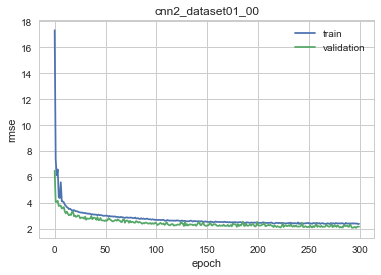

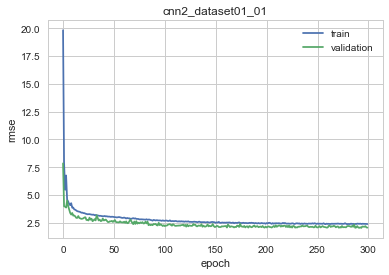

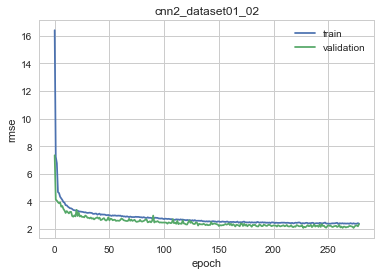

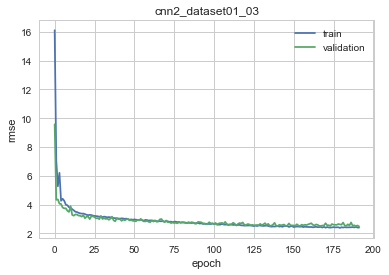

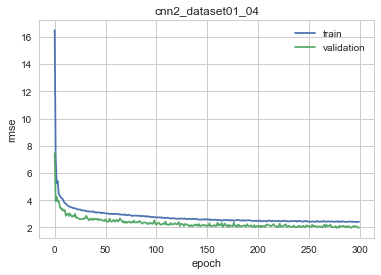

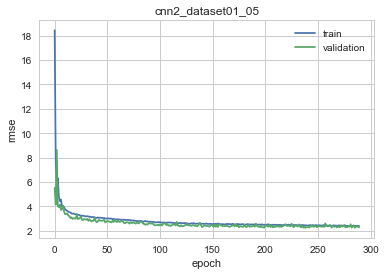

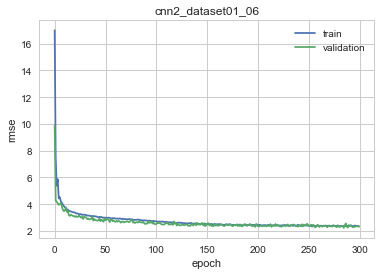

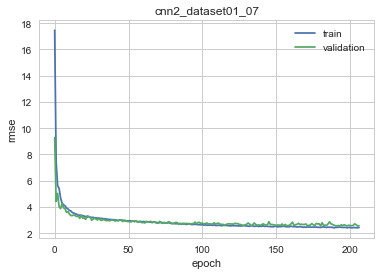

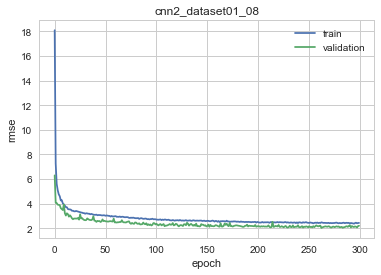

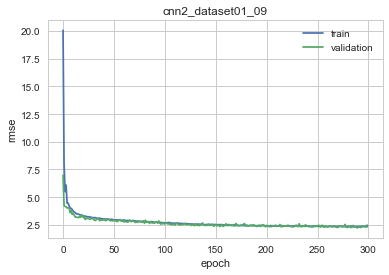

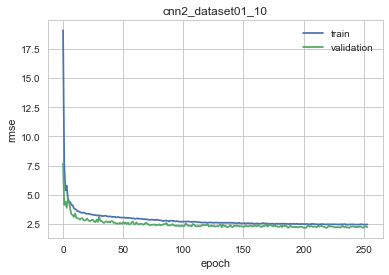

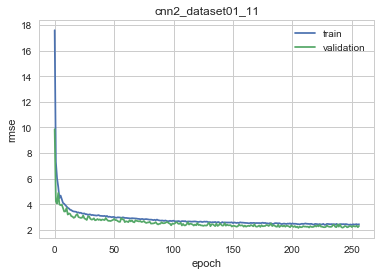

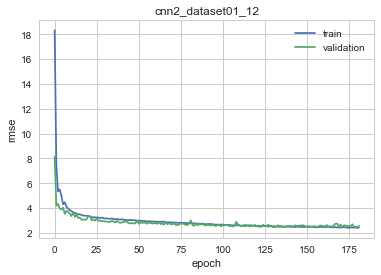

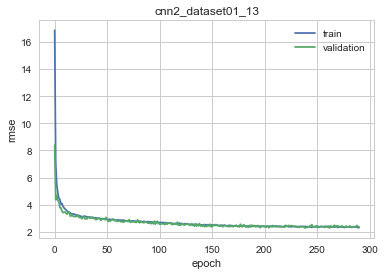

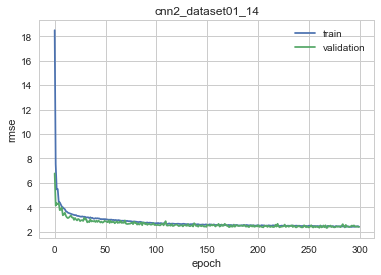

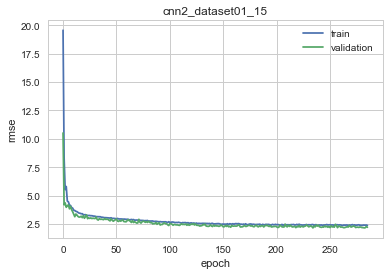

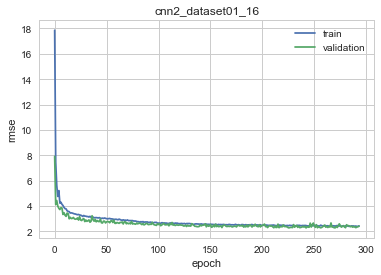

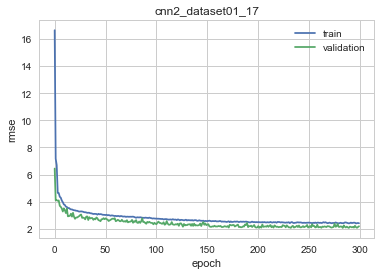

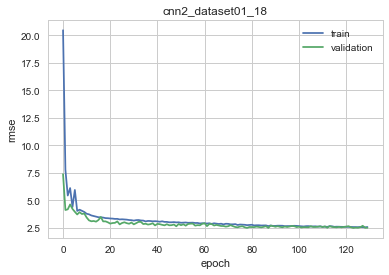

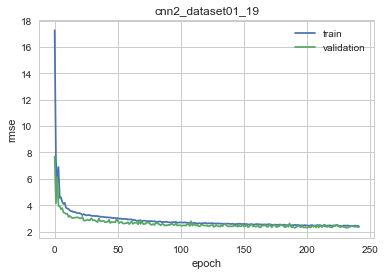

In [8]:
plot_loss_history(model_name, 'cnn2_dataset01')

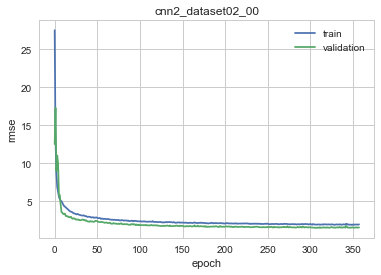

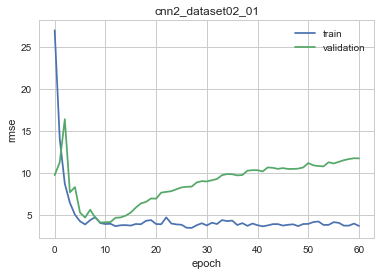

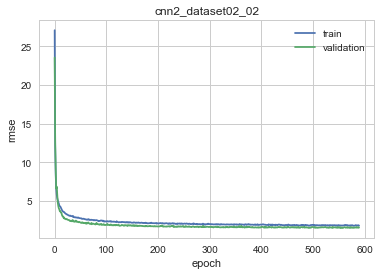

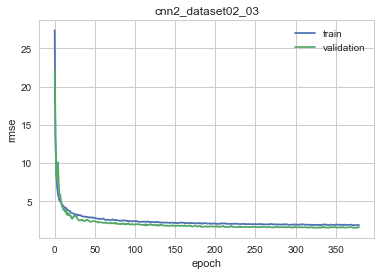

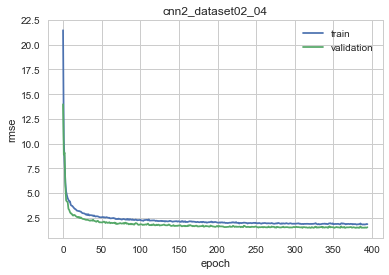

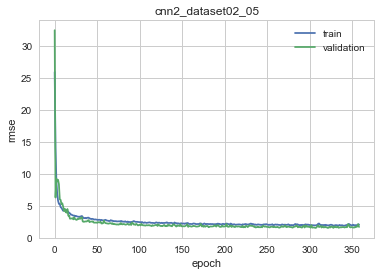

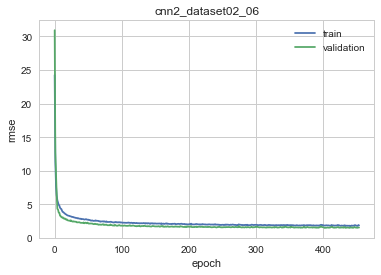

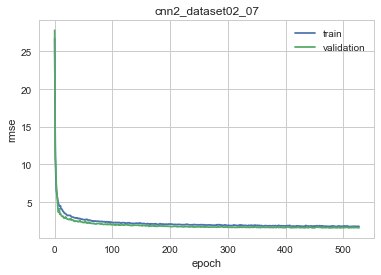

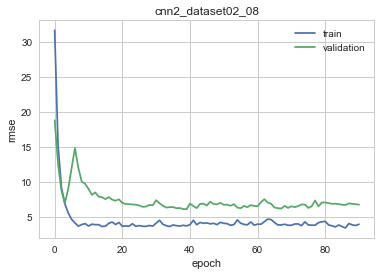

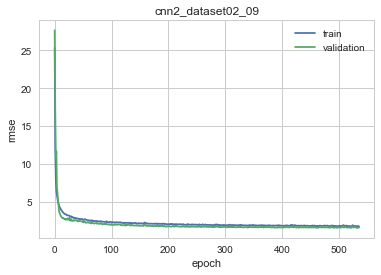

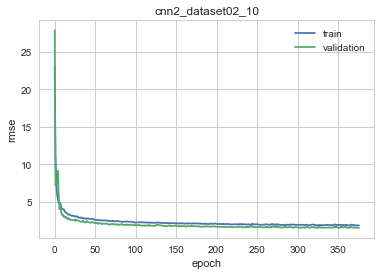

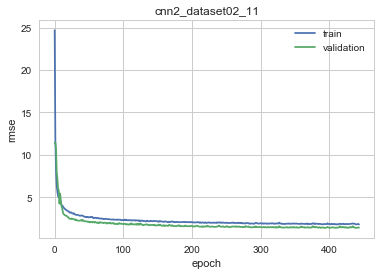

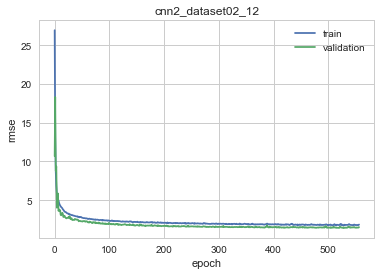

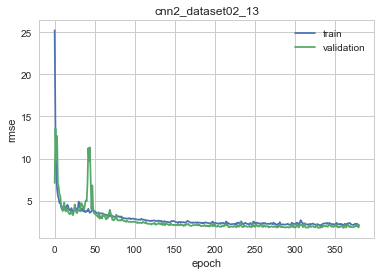

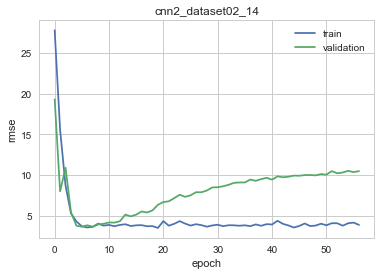

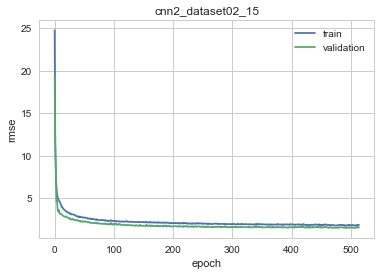

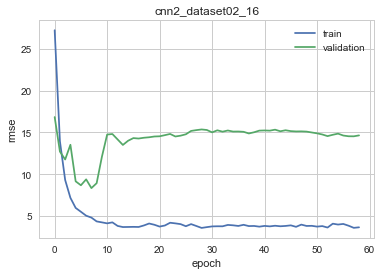

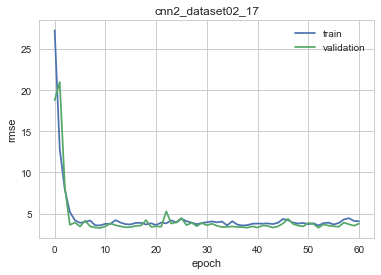

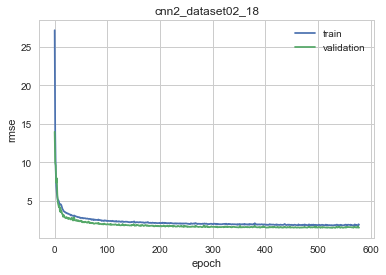

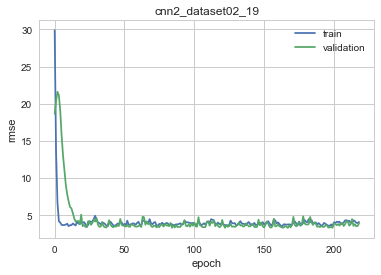

In [9]:
plot_loss_history(model_name, 'cnn2_dataset02')

* Dataset01에 대한 서브모델에서 가장 좋은 성은은 cnn2_Dataset01_04
* Dataset02에 대한 서브모델에서 가장 좋은 성은은 cnn2_Dataset02_25

In [10]:
best_ones = pick_cnns(model, [4], [25])
predicted = predict(X_test, best_cnns)
submission = create_submission(predicted)
datetime = dt.datetime.now().strftime("%Y%m%d_%H%M")
filename = 'submission_' + datetime + '.csv'
submission.to_csv(filename, index_label='RowId')

NameError: name 'best_cnns' is not defined

# submission_20171120_0116.csv
* RMSE: <strong>2.25358</strong>
* 성능 좋은 애들로 모아서 앙상블 모델을 만들어서 예측해보자.

In [ ]:
indexes08 = [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19] 
indexes22 = [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 18, 21, 22, 25, 27, 29]

In [ ]:
selected_ensemble = pick_cnns(model, indexes08, indexes22)

In [ ]:
predicted = predict(X_test, selected_ensemble)
submission = create_submission(predicted)
datetime = dt.datetime.now().strftime("%Y%m%d_%H%M")
filename = 'submission_' + datetime + '.csv'
submission.to_csv(filename, index_label='RowId')

# submission_20171120_0132.csv
* RMSE: <strong>2.14311</strong>
* OpenCV2로 얼굴을 인식하고 거기에서 예측해보자.

In [ ]:
import random
idx = random.randint(0, len(X_test))
# idx = 1192
print(idx)

img = to_img(X_test[idx].reshape(-1)*255)

cv2_img = np.array(img)[:, :, ::-1].copy()
cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
image_with_detections = np.copy(cv2_img)
    
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('image')    



# landmarks2 = predict(np.array([X_test[idx]]), selected_ensemble)
# ax1.scatter(landmarks2[0, 0::2], landmarks2[0, 1::2], marker='o', c='r', s=15)

landmarks2 = predict_with_cnn_cv2(np.array([X_test[idx]]), selected_ensemble)
ax1.scatter(landmarks2[0, 0::2], landmarks2[0, 1::2], marker='o', c='c', s=15)

landmarks =  predict_with_cnn_cv3(X_test[idx].reshape(-1, 96, 96, 1), selected_ensemble)
ax1.scatter(landmarks[0, 0::2], landmarks[0, 1::2], marker='o', c='r', s=15)

# landmarks3 = (landmarks + landmarks2) / 2.0
# ax1.scatter(landmarks3[0, 0::2], landmarks3[0, 1::2], marker='o', c='y', s=15)

ax1.imshow(image_with_detections, cmap='gray')

# 어이없는 사진들
# 956(전신초상화), 694, 1064, 951(얼굴 두개)

# 어려운 사진들
# 962(흑인원주민), 511클로즈업

# 대체적으로 얼굴이 기울어 있거나 옆모습 화질이 안좋은 이미지 같은 경우는 OpenCV2로 인식해서 예측하면 저 좋음
# ex) 1427, 1615, 960, 1192

# 얼굴 일부분이 잘려 있는 경우 OpenCV2같은 경우 얼굴을 인식을 잘 못해서 잘못된 얼굴 인식부분에서 예측해서 안 좋음
# ex) 310, 428
# 얼굴예측한 부분이 너무 작으면 cnn것을 사용하자

# 사진에 얼굴이 두개 있는 경우는 어떻게 해야 할까? 
# NA로 채워서 보내보자

# cnn이 cnncv2보다 좋은 성능 내는 사진들
# 216, 714, 835, 1586, 1342


In [ ]:
predicted = predict_with_cnn_cv2(X_test, selected_ensemble)
submission = create_submission(predicted)
datetime = dt.datetime.now().strftime("%Y%m%d_%H%M")
filename = 'submission_' + datetime + '.csv'
submission.to_csv(filename, index_label='RowId')

In [ ]:

from imgaug import augmenters as iaa
import random

seq = iaa.Sequential([
    iaa.PerspectiveTransform(scale=(0.01, 0.1))
])
# print(X_test[0])
temp_aug = seq.augment_images(X_test[0:10]*255)/255
print(temp_aug)
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])
print(temp)
ax1.imshow(to_img(temp_aug.reshape(-1)*255), cmap='gray')
            

13